### GAN USPS one class classifier

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn import utils
import matplotlib.pyplot as plt

dataPath = './data/'
def prepare_usps_mlfetch():

    import tempfile
    import pickle
    print "importing usps from pickle file ....."

    with open(dataPath+'usps_data.pkl', "rb") as fp:
          loaded_data1 = pickle.load(fp)

    # test_data_home = tempfile.mkdtemp()
    # from sklearn.datasets.mldata import fetch_mldata
    # usps = fetch_mldata('usps', data_home=test_data_home)
    # print usps.target.shape
    # print type(usps.target)
    labels = loaded_data1['target']
    data = loaded_data1['data']
    # print "******",labels

    k_ones = np.where(labels == 2)
    label_ones = labels[k_ones]
    data_ones = data[k_ones]

    k_sevens = np.where(labels == 8)
    label_sevens = labels[k_sevens]
    data_sevens = data[k_sevens]
    #
    # print "data_sevens:",data_sevens.shape
    # print "label_sevens:",label_sevens.shape
    # print "data_ones:",data_ones.shape
    # print "label_ones:",label_ones.shape
    #
    data_ones = data_ones[:220]
    label_ones= label_ones[:220]
    data_sevens = data_sevens[:11]
    label_sevens = label_sevens[:11]

    data = np.concatenate((data_ones,data_sevens),axis=0)
    label = np.concatenate((label_ones,label_sevens),axis=0)
    label[0:220] = 1
    label[220:231] = 0
    # print "1-s",data[0]
    # print label
    # print "7-s",data[230]
    # print label
    # print "data:",data.shape
    # print "label:",label.shape
    return [data,label]



###  Develop a GAN_Tflearn model as one class classifier

Training Step: 149  | total loss: 4.48276 | time: 0.075s
| GEN | epoch: 010 | loss: 0.44918 -- iter: 224/231
| DISC | epoch: 010 | loss: 4.03358 -- iter: 224/231
Training Step: 150  | total loss: 4.37256 | time: 0.080s
| GEN | epoch: 010 | loss: 0.49643 -- iter: 231/231
| DISC | epoch: 010 | loss: 3.87613 -- iter: 231/231
--


/Users/raghav/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


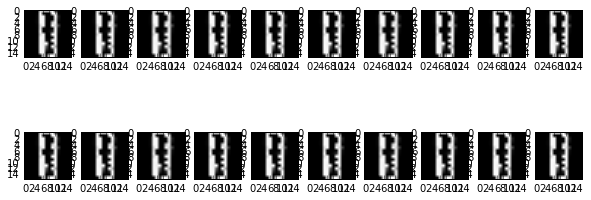

In [2]:


import tensorflow as tf
import tflearn
import numpy as np
from scipy.io import loadmat
import os,sys

#load data from usps dataset
image_dim = 256 # 16*16 pixels
z_dim = 256 # 16*16 pixels

[Xtrue,Xlabels] = prepare_usps_mlfetch()
X = Xtrue
#convert X to range in 0 ~ 1
X=(X+1)/2
Y = Xlabels
print "data shape...",X.shape


# Generator
def generator(x, reuse=False):
    with tf.variable_scope('Generator', reuse=reuse):
        x = tflearn.fully_connected(x, 256, activation='relu')
        x = tflearn.fully_connected(x, image_dim, activation='sigmoid')
        return x


# Discriminator
def discriminator(x, reuse=False):
    with tf.variable_scope('Discriminator', reuse=reuse):
        x = tflearn.fully_connected(x, 256, activation='relu')
        x = tflearn.fully_connected(x, 1, activation='sigmoid')
        return x

# # Build Networks
gen_input = tflearn.input_data(shape=[None, z_dim], name='input_gen')
disc_input = tflearn.input_data(shape=[None, 256], name='input_disc')

gen_sample = generator(gen_input)
disc_real = discriminator(disc_input)
disc_fake = discriminator(gen_sample, reuse=True)

# # Define Loss
disc_loss = -tf.reduce_mean(tf.log(disc_real) + tf.log(1. - disc_fake))
gen_loss = -tf.reduce_mean(tf.log(disc_fake))

# Build Training Ops for both Generator and Discriminator.
# Each network optimization should only update its own variable, thus we need
# to retrieve each network variables (with get_layer_variables_by_scope) and set
# 'placeholder=None' because we do not need to feed any target.
gen_vars = tflearn.get_layer_variables_by_scope('Generator')
gen_model = tflearn.regression(gen_sample, placeholder=None, optimizer='adam',
                               loss=gen_loss, trainable_vars=gen_vars,
                               batch_size=16, name='target_gen', op_name='GEN')

disc_vars = tflearn.get_layer_variables_by_scope('Discriminator')
disc_model = tflearn.regression(disc_real, placeholder=None, optimizer='adam',
                                loss=disc_loss, trainable_vars=disc_vars,
                                batch_size=16, name='target_disc', op_name='DISC')

# Define GAN model, that output the generated images.
gan = tflearn.DNN(gen_model)

# Training
# Generate noise to feed to the generator
total_samples = len(X)
# z = np.random.uniform(-1., 1., size=[total_samples, z_dim])

# Start training, feed both noise and real images.
gan.fit(X_inputs={gen_input: X, disc_input: X},
        Y_targets=Y,
        n_epoch=200)

# Generate images from noise, using the generator network.
f, a = plt.subplots(2, 10, figsize=(10, 4))
for i in range(10):
    for j in range(2):
        # Noise input.
#         z = np.random.uniform(-1., 1., size=[1, z_dim])
        # Generate image from noise. Extend to 3 channels for matplot figure.
        temp = [[ii, ii, ii] for ii in list(gan.predict([X])[0])]
        a[j][i].imshow(np.reshape(temp, (16, 16, 3)))
f.show()
plt.draw()


In [5]:
gan.predict([z]).shape


(1, 256)

In [3]:
temp.shape

AttributeError: 'list' object has no attribute 'shape'